In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools

from functools import reduce

spm = pd.read_csv('SPM/SPM_results.csv', sep=',')
scc_col = pd.read_csv('SCC/SCC_COL_results.csv', sep=',')
scc_fb = pd.read_csv('SCC/SCC_FB_results.csv', sep=',')
sorting = pd.read_csv('sorting/sorting_results.csv', sep=',')
prefix_sum = pd.read_csv('prefix_sum/prefix_sum_results.csv', sep=',')
synthesis = pd.read_csv('synthesis/synthesis_results.csv', sep=',')

all_data = [spm, scc_col, scc_fb, sorting, prefix_sum, synthesis];
cols = list(map((lambda d : d.columns), all_data));
assert (all([all(cols[i-1] == cols[i]) for i in range(1, len(cols))]));

data = pd.concat(all_data, ignore_index=True);

data


,memorder,schedule,voting-strat,weak_non_racing,algorithm,problem_type,problem_size,runtime
0,relaxed,graph,graph-shared,1,SPM,Invariantly Inevitably Eat,794,9.894993
1,relaxed,graph,graph-shared,1,SPM,Invariantly Inevitably Eat,11014,96.32407
2,relaxed,graph,graph-shared,1,SPM,Invariantly Inevitably Eat,149262,1366.6097
3,relaxed,graph,graph-shared,1,SPM,Invariantly Inevitably Eat,1972036,137929.47
4,relaxed,graph,graph-shared,1,SPM,Invariantly Plato Starves,678,0.6739584
...,...,...,...,...,...,...,...,...
639,acqrel,in-kernel,in-kernel-simple,0,synthesis,Random,23001871,303.73926
640,relaxed,graph,graph-shared-banks,1,synthesis,Random,23030,0.506646
641,relaxed,graph,graph-shared-banks,1,synthesis,Random,229856,1.002864
642,relaxed,graph,graph-shared-banks,1,synthesis,Random,2298699,9.505226


In [68]:
data = data.drop(data[data["runtime"] == "timeout"].index);
data["runtime"] = data["runtime"].astype(float);
data["problem_size"] = data["problem_size"].astype(int);
data["weak_non_racing"] = data["weak_non_racing"].astype(bool);

data[data["algorithm"] == "SCC_COL"]["problem_size"].unique()

array([   11512,   114814,  1149534, 11502185])

In [3]:
""" Returns all rows with a configuration that is present
    for all possible values of variable_parameter, such that
    the only configuration-related difference between rows 
    is the variable_parameter.
"""
def get_comparable_rows(all_rows, rows, variable_parameter):
    # Group rows by config, except for the variable_parameter
    config_cols = [
        "memorder",
        "schedule",
        "voting-strat",
        "weak_non_racing",
        "algorithm",
        "problem_type",
        "problem_size"
    ];
    config_cols.remove(variable_parameter);
    
    # Compute all available variable_parameter options
    p_options = all_rows[variable_parameter].unique();
    
    # Per possible value of variable_parameter, get the corresponding rows
    rows_per_option = [rows[rows[variable_parameter] == opt] for opt in p_options];
    
    # Find the unique configs present per value of variable_parameter
    sets_of_configs = [set(r.groupby(config_cols).groups.keys()) for r in rows_per_option];
    
    # Get configs which are present for all possible values of variable_parameter
    shared_configs = list(reduce((lambda x, y : x & y), sets_of_configs));
    
    # Return all rows which have a shared config
    by_config = rows.groupby(config_cols);
    comp_rows = [];
    for (c, c_rows) in by_config:
        if c in shared_configs:
            comp_rows.append(c_rows);
    if comp_rows == []:
        print("WARNING: EMPTY ROWS TO COMPARE");
        return pd.DataFrame(data={});
    comparable_rows = pd.concat(comp_rows);
        
    return comparable_rows;


In [4]:
def bar_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    tot_width = 0.8;
    width = tot_width / len(ordering);
    offset = - 0.5 * tot_width + 0.5 * width;
    
    ys = [];
    p_sizes = list(rows["problem_size"].unique());
    p_sizes.sort();
    nrof_values = len(p_sizes);
    
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        Y = rows.groupby("problem_size")["runtime"].mean();
        assert(nrof_values == len(Y.values));
        X = [x + offset for x in range(len(Y.values))];
        ys.append(Y);
        plt.bar(X, Y.values, width=width, label=o);
        offset += width;
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.xticks(range(nrof_values), [str(round(p, -3)/1000)+"K" for p in p_sizes]);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();
    return ys;

def scatter_chart(all_rows, rows, title, variable_parameter, ordering=None, yscale="log", xlabel="Problem size", xscale="linear"):
    if ordering == None:
        ordering = all_rows[variable_parameter].unique();
    assert (len(ordering) == len(all_rows[variable_parameter].unique()))
    
    plt.figure();
    plt.title(title);
    rows = get_comparable_rows(all_rows, rows, variable_parameter);
    cols = ["C0", "C1", "C2", "C3", "C4", "C5"];
    col_idx = 0;
    for o, rows in [(o, rows[rows[variable_parameter] == o]) for o in ordering]:
        for c, rows in rows.groupby("config"):
            plt.plot(rows["problem_size"], rows["runtime"], color=cols[col_idx % len(cols)], label=o);
        col_idx += 1;
    
    plt.xlabel(xlabel);
    plt.xscale(xscale);
    plt.yscale(yscale);
    plt.ylabel("runtime (ms)");
    patches = [mpatches.Patch(color=cols[i % len(cols)], label=ordering[i]) for i in range(len(ordering))];
    plt.legend(handles=patches, bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

In [94]:
def memorder_chart(rows, title, column, order):
    assert(len(rows["algorithm"].unique()) == 1);
    assert(len(rows["problem_type"].unique()) == 1);
    
    plt.figure();
    plt.title(title);
    cols = {
        "relaxed": "C0",
        "acqrel": "C2",
        "seqcons": "C1"
    };
    
    for w in [0, 1]:
        w_rows = rows[rows["weak_non_racing"] == w];
        ref_Y = w_rows[w_rows[column] == order[0]].groupby("problem_size")["runtime"].mean();
        for o in order:
            o_gr = w_rows[w_rows[column] == o].groupby("problem_size");
            Y = (o_gr["runtime"].mean() / ref_Y) * 100;
            X = sorted(list(o_gr.indices.keys()));
            print("REF:" + str(ref_Y));
            print("X: " + str(X));
            print("Y: " + str(Y));
            l = f"{o}{'-opt' if w == 1 else ''}";
            ls = "-" if w == 1 else "--";
            plt.plot(X, Y, color=cols[o], label=l, linestyle=ls);
    plt.xscale("log");
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");
    plt.show();

REF:problem_size
11512         2.437991
114814        4.279363
1149534       7.130226
11502185    135.296583
Name: runtime, dtype: float64
X: [11512, 114814, 1149534, 11502185]
Y: problem_size
11512       100.0
114814      100.0
1149534     100.0
11502185    100.0
Name: runtime, dtype: float64
REF:problem_size
11512         2.437991
114814        4.279363
1149534       7.130226
11502185    135.296583
Name: runtime, dtype: float64
X: [11512, 114814, 1149534, 11502185]
Y: problem_size
11512       122.099120
114814      117.476374
1149534     154.549496
11502185    112.318604
Name: runtime, dtype: float64
REF:problem_size
11512         2.437991
114814        4.279363
1149534       7.130226
11502185    135.296583
Name: runtime, dtype: float64
X: [11512, 114814, 1149534, 11502185]
Y: problem_size
11512       131.525409
114814      129.050845
1149534     188.199390
11502185    120.896702
Name: runtime, dtype: float64
REF:problem_size
11512         1.946994
114814        3.314294
1149534     

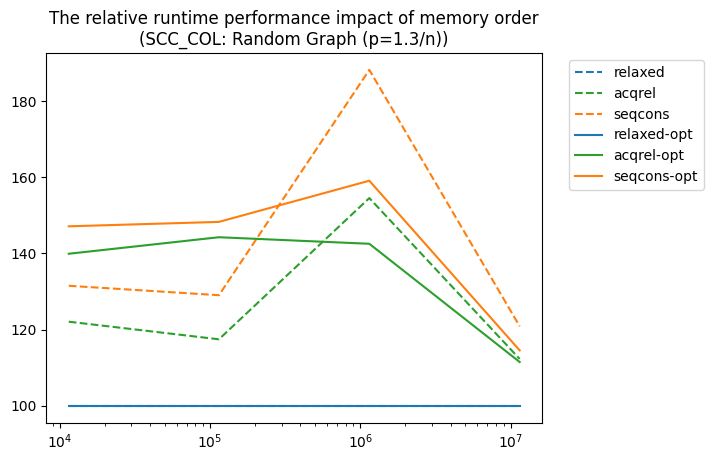

REF:problem_size
11512         73.744024
114814      1682.588353
1149534    43825.389333
Name: runtime, dtype: float64
X: [11512, 114814, 1149534]
Y: problem_size
11512      100.0
114814     100.0
1149534    100.0
Name: runtime, dtype: float64
REF:problem_size
11512         73.744024
114814      1682.588353
1149534    43825.389333
Name: runtime, dtype: float64
X: [11512, 114814, 1149534]
Y: problem_size
11512      133.186003
114814     125.148439
1149534    108.084741
Name: runtime, dtype: float64
REF:problem_size
11512         73.744024
114814      1682.588353
1149534    43825.389333
Name: runtime, dtype: float64
X: [11512, 114814, 1149534]
Y: problem_size
11512      146.347229
114814     131.586746
1149534    131.447887
Name: runtime, dtype: float64
REF:problem_size
11512         59.328319
114814      1402.720620
1149534    36937.998875
Name: runtime, dtype: float64
X: [11512, 114814, 1149534]
Y: problem_size
11512      100.0
114814     100.0
1149534    100.0
Name: runtime, dtype: fl

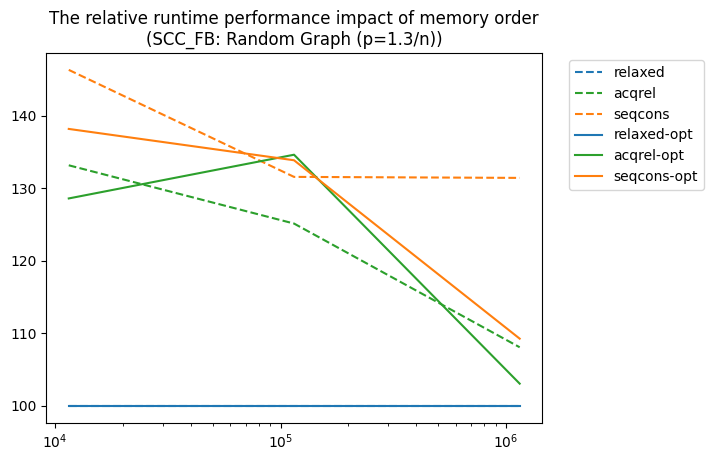

REF:problem_size
794            15.165129
11014         170.515327
149262       3938.721133
1972036    179594.330000
Name: runtime, dtype: float64
X: [794, 11014, 149262, 1972036]
Y: problem_size
794        100.0
11014      100.0
149262     100.0
1972036    100.0
Name: runtime, dtype: float64
REF:problem_size
794            15.165129
11014         170.515327
149262       3938.721133
1972036    179594.330000
Name: runtime, dtype: float64
X: [794, 11014, 149262]
Y: problem_size
794        158.914756
11014      148.301199
149262     153.122058
1972036           NaN
Name: runtime, dtype: float64


ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

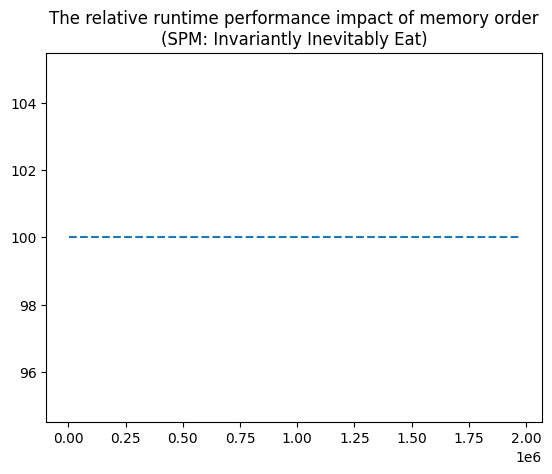

In [95]:
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        memorder_chart(
            p_type_rows,
            f"The relative runtime performance impact of memory order\n({alg}: {p_type})",
            "memorder",
            ["relaxed", "acqrel", "seqcons"]
        );
#         ys = bar_chart(
#             data,
#             p_type_rows,
#             f"Runtime of each memory order compared\n({alg}: {p_type})",
#             "memorder",
#             ["relaxed", "acqrel", "seqcons"],
#         );
        
#         scatter_chart(
#             data,
#             p_type_rows,
#             f"Runtime of each memory order compared\n({alg}: {p_type})",
#             "memorder",
#         );
        
#         ys = bar_chart(
#             data,
#             p_type_rows,
#             f"Runtime of each voting strategy compared\n({alg}: {p_type})",
#             "voting-strat",
#             ["naive-alternating", "naive"],
#         );
        
#         ys = bar_chart(
#             data,
#             p_type_rows,
#             f"Runtime of each division strategy compared\n({alg}: {p_type})",
#             "division_strat",
#             ["blocksize", "gridsize"],
#         );
        
#         ys = bar_chart(
#             data,
#             p_type_rows,
#             f"Runtime impact of weak loads of read-only data\n({alg}: {p_type})",
#             "weak_read_only",
#             [1, 0],
#         );
        
#         ys = bar_chart(
#             data,
#             p_type_rows,
#             f"Runtime of threads per block compared\n({alg}: {p_type})",
#             "tpb",
#         );

In [ ]:
config_parameters = [
    ("memorder", ["relaxed", "acqrel", "seqcons"]),
    ("voting-strat", ["naive-alternating", "naive"]),
    ("weak_read_only", [1, 0]),
    ("division_strat", ["gridsize", "blocksize"])
];
    
multi_indices = [
    pd.MultiIndex.from_tuples(
        [("", "algorithm"), ("", "problem_type"), ("", "problem_size")]
    )
];
for (c, opts) in config_parameters:
    multi_indices.append(
        pd.MultiIndex.from_product(
            [
                [c],
                opts + ["#configs"]
            ],
            names=['optimisation technique', 'variant']
        )
    )

table_columns = reduce(lambda x, y : x.append(y), multi_indices);

table_data = [];
runtime_cols = [];
config_cols = [];
cols_done = False;
for alg, alg_rows in data.groupby("algorithm"):
    for p_type, p_type_rows in alg_rows.groupby("problem_type"):
        for p_size, p_size_rows in p_type_rows.groupby("problem_size"):
            current_row = [alg, p_type, p_size];
            for (c, opts) in config_parameters:
                if not cols_done:
                    runtime_cols += list(range(len(current_row), len(current_row)+len(opts)));
                    config_cols += [len(current_row)+len(opts)];
                rows = get_comparable_rows(data, p_size_rows, c);
                nrof_comp_rows = len(rows.index);
                if nrof_comp_rows == 0:
                    current_row += ["-"] * len(opts);
                else:
                    mean_runtimes = [rows[rows[c] == o]["runtime"].mean() for o in opts];
                    relative_runtimes = [mean_runtimes[i]/mean_runtimes[0] for i in range(len(mean_runtimes))];
                    as_percentage = ["{0:.0%}".format((f-1)) for f in relative_runtimes];
                    current_row += as_percentage;
                current_row += [int(nrof_comp_rows/len(opts))];
            table_data.append(current_row);
            cols_done = True;
runtime_cols = [table_columns[i] for i in runtime_cols];
config_cols = [table_columns[i] for i in config_cols];

table = pd.DataFrame(data=table_data, columns = table_columns);


In [ ]:
def color_performance(val):
    if val == "0%":
        color = "black";
    elif val.startswith("-"):
        color = "green";
    else:
        color = "red";

    return 'color: {}'.format(color)

def border(val):
    return 'border-right: 1px solid black';

styled_table = table.style.applymap(color_performance, 
                  subset=runtime_cols).applymap(border, subset= [("", "problem_size")] + config_cols);

styled_table.to_excel(r'results_table.xlsx', index=True)
